# Blockage modelling 1

## Wind farm blockage

This example shows how to use the Rankine-Half-Body model for modelling the blockage effect. We need the following imports:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import foxes
import foxes.variables as FV
import foxes.constants as FC

First, we setup the model book and the wind farm, here we pick 20 x 10 turbines on a regular grid:

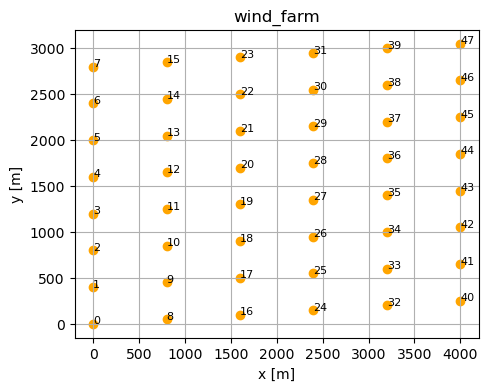

In [2]:
farm = foxes.WindFarm()
foxes.input.farm_layout.add_grid(
    farm=farm,
    xy_base=[0.0, 0.0],
    step_vectors=[[800.0, 50.0], [0., 400.0]],
    steps=[6, 8],
    turbine_models=["DTU10MW"],
    verbosity=0
)

ax = foxes.output.FarmLayoutOutput(farm).get_figure(figsize=(8, 4))
plt.show()

As wind conditions, we choose a single wind direction state from 270 degrees:

In [3]:
# create ambient wind conditions, a single uniform state:
states = foxes.input.states.SingleStateStates(ws=8.0, wd=270.0, ti=0.04, rho=1.225)

For induction models, the `Iterative` algorithm should be invoked. This is due to the fact that upstream turbines can be influenced by the induction zone of a turbine, which the `Downstream` algorithm simply would not notice.

By default the `Iterative` algorithm adds a smooth cutin region to the thrust coefficient curve. This behaviour can be changed by modifying the default choice of the constructor argument `mod_cutin={modify_ct=True, modify_P=False}`. Alternatively, under-relaxation of the variable `FV.CT` could by applied, e.g. by calling `aglo.set_urelax(pre_wake={FV.CT: 0.5})` before calculations. This means that for each iteration the freshly calculated value is mixed with the result from the previous iteration. Both approaches avoid wakes switching on and off repeatedly between subsequent iterations in some cases, ensuring convergence also in the vicinity of the cut-in and cut-out regions of the thrust curve. The convergence criteria can also be modified by setting the parameter `conv_crit`, see API.

In [4]:
algo = foxes.algorithms.Iterative(
    farm,
    states,
    rotor_model="centre",
    wake_models=["RHB", "Bastankhah025_linear_lim_k004"],
    wake_frame="rotor_wd",
    partial_wakes="grid36",
    chunks={FC.STATE: None, FC.POINT: 4000},
    verbosity=1,
)

Notice the `RHB` model among the list of wake models. This is the [Rankine-Half-Body](https://www.fnc.co.uk/media/o5eosxas/a-potential-flow-model-for-wind-turbine-induction-and-wind-farm-blockage.pdf) induction model, adding an induction zone for each turbine. We can now calculate the results:

In [5]:
with foxes.utils.runners.DaskRunner() as runner:
    farm_results = runner.run(algo.calc_farm)

print(farm_results)


Algorithm Iterative: Iteration 0


Initializing algorithm 'Iterative'
Initializing model 'Iterative'
Initializing model 'SingleStateStates'
Initializing model 'centre'
Initializing model 'basic_ctrl_prer'
Initializing model 'DTU10MW'
Turbine type 'DTU10MW': Reading static data from context 'power_ct_curve'
Path: C:\Users\varav\anaconda3\Lib\site-packages\foxes\data\power_ct_curves\DTU-10MW-D178d3-H119.csv
Initializing model 'basic_ctrl_postr'
Initializing model 'basic_ctrl'
Initializing model 'rotor_wd'
Initializing model 'Madsen'
Initializing model 'RHB'
Initializing model 'WakeK'
Initializing model 'Bastankhah025_linear_lim_k004'
Initializing model 'GridRotor'
Initializing model 'grid36'

--------------------------------------------------
  Running Iterative: calc_farm
--------------------------------------------------
  n_states : 1
  n_turbines: 48
--------------------------------------------------
  states   : SingleStateStates()
  rotor    : CentreRotor()
  controller: BasicFarm

The following visualizes the flow field around the most south-westerly turbine in the wind farm:

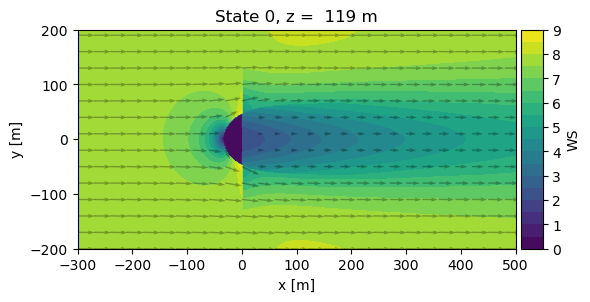

In [6]:
o = foxes.output.FlowPlots2D(algo, farm_results)
g = o.gen_states_fig_xy(
    FV.WS,
    figsize=(6, 5),
    resolution=2,
    xmin=-300, xmax=500,
    ymin=-200, ymax=200,
    levels=20,
    quiver_n=15,
    quiver_pars={"scale": 0.25, "alpha": 0.3}
)
fig = next(g)
plt.show()

The induction zone in front of the rotor is clearly visible. For the complete wind farm, the individual induction zones merge:

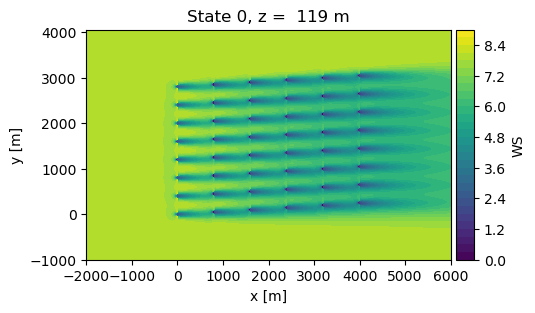

In [7]:
o = foxes.output.FlowPlots2D(algo, farm_results)
g = o.gen_states_fig_xy(
    FV.WS,
    figsize=(5, 5),
    resolution=10,
    xspace=2000,
    yspace=1000,
    levels=30,
)
fig = next(g)
plt.show()

The individual contributions to the blockage zone are visible when plotting the wind speed along a straight line in y direction, at fixed x in front of the first row of turbines:

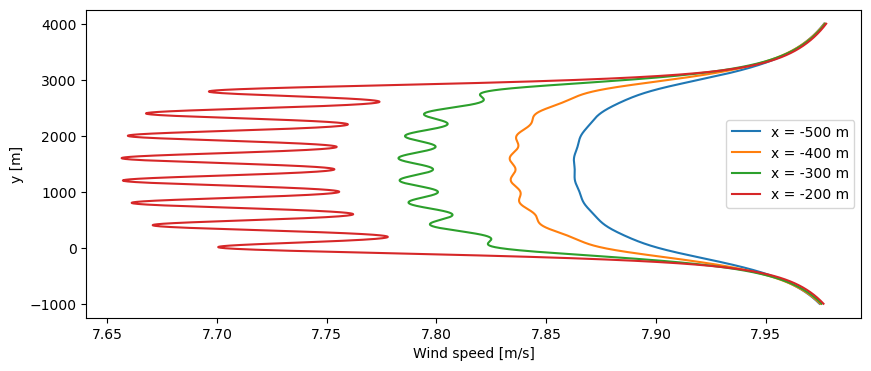

In [8]:
H = algo.mbook.turbine_types["DTU10MW"].H
n_points = 10000
points = np.zeros((1, n_points, 3))
points[:, :, 1] = np.linspace(-1000, 4000, n_points)[None, :]
points[:, :, 2] = H

xlist = [-500, -400, -300, -200]
fig, ax = plt.subplots(figsize=(10, 4))
for x in xlist:
    points[:, :, 0] = x
    point_results = algo.calc_points(farm_results, points)
    ax.plot(point_results[FV.WS][0, :], points[0, :, 1], label=f"x = {x} m")
ax.set_ylabel("y [m]")
ax.set_xlabel("Wind speed [m/s]")
ax.legend()
plt.show()

Now we investigate the effect of mirroring turbines to account for the speed up effect due to the constrictions from the ground and boundary layer. For this we create a wind farm which consists of only one turbine:

In [9]:
farm = foxes.WindFarm()
farm.add_turbine(foxes.Turbine(xy=[0., 0.], turbine_models=["DTU10MW"]))

Turbine 0, T0: xy=(0.00, 0.00), DTU10MW


Here we calculate farm results for 3 scenarios using only the Rankine Half Body model:
1) No ground effect
2) Using the ground as mirror
3) Using the height 500m as a mirror for the boundary layer

A flow plot for each scenario is generated, along with a windspeed profile comparison.


Algorithm Iterative: Iteration 0

[########################################] | 100% Completed | 103.72 ms
[########################################] | 100% Completed | 103.45 ms
[########################################] | 100% Completed | 102.70 ms
[########################################] | 100% Completed | 104.89 ms
[########################################] | 100% Completed | 102.86 ms
[########################################] | 100% Completed | 104.20 ms
[########################################] | 100% Completed | 102.69 ms
[########################################] | 100% Completed | 102.92 ms
[########################################] | 100% Completed | 106.02 ms
[########################################] | 100% Completed | 104.22 ms

Algorithm Iterative: Iteration 0

[########################################] | 100% Completed | 102.69 ms
[########################################] | 100% Completed | 103.24 ms
[########################################] | 100% Completed | 103.

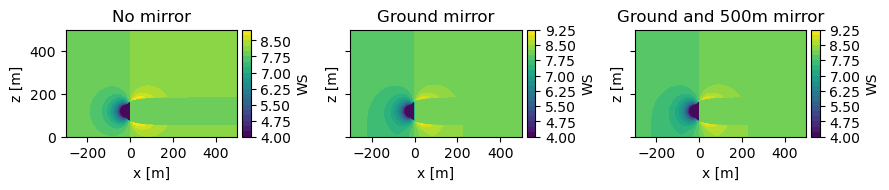

In [10]:
# set up figure
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
ax = axs.ravel()
vmin = states.ws * 0.5
vmax = None
npoints = 10000
profile_pts = np.ndarray(shape=(npoints, 2, 3))

bmodel = "RHB"
mirror_combo = {
    "No mirror": None,
    "Ground mirror": "ground_mirror",
    "Ground and 500m mirror": "blh_mirror_h500",
}

with foxes.utils.runners.DaskRunner() as runner:
    for i, (mirror, gmodel) in enumerate(mirror_combo.items()):

        algo = foxes.algorithms.Iterative(
            farm,
            states,
            rotor_model="centre",
            wake_models=[bmodel],
            wake_frame="rotor_wd",
            partial_wakes="grid36",
            ground_models=gmodel,
            chunks={FC.STATE: None, FC.POINT: 4000},
            verbosity=0,
        )

        farm_results = runner.run(algo.calc_farm)

        o = foxes.output.FlowPlots2D(algo, farm_results, runner=runner)
        g = o.gen_states_fig_xz(
            var=FV.WS, resolution=2, 
            fig=fig, ax=ax[i], 
            xmin=-300, xmax=500,
            zmin=0, zmax=500,
            levels=20, 
            vmin=vmin, vmax=vmax, 
            title=mirror,
        )
        fig = next(g)

        # get point data for profile plot and store in df
        points = np.zeros((1, npoints, 3))
        points[:, :, 0] = -200
        points[:, :, 1] = 0
        points[:, :, 2] = np.linspace(0, 500, npoints)[None, :]
        point_results = runner.run(algo.calc_points, args=(farm_results, points))
        profile_pts[:, 0, i] = point_results[FV.WS][0, :] # x points, WS
        profile_pts[:, 1, i] = points[0, :, 2] #  y points, z values

fig.tight_layout()
plt.show()

Now we plot the wind speed profile in front of the row of turbines at x=-200 and y=0. Here we observe the additional blockage effect caused by the mirrored turbines:

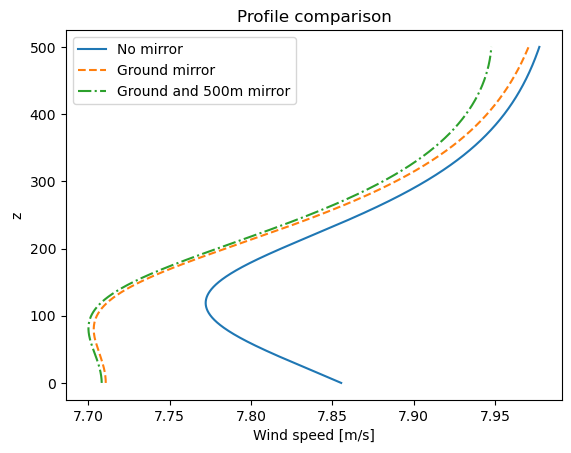

In [11]:

fig, ax = plt.subplots()
lines = ["-","--","-.",":"]
for i, mirror, in enumerate(mirror_combo):
    ax.plot(profile_pts[:,0,i],profile_pts[:,1,i], label=mirror, linestyle=lines[i])
ax.set_title(f'Profile comparison')
ax.set_ylabel("z")
ax.set_xlabel("Wind speed [m/s]")
plt.legend()
plt.show()

While the ground mirror seems to have a noticable effect in this example, the reflection from the imagined top of the boundary layer at 500 m seems to be small at the rotor relevant heights.

Let's finish by looking at the flow in a more realistic modelling setting. As an example, we apply the `SelfSimilar2020` induction model with ground effects to a stable ambient wind speed profile, and combine this with the `Bastankhah2016` wake deficit model without ground mirroring:


Algorithm Iterative: Iteration 0

[########################################] | 100% Completed | 102.73 ms
[########################################] | 100% Completed | 103.56 ms
[########################################] | 100% Completed | 102.91 ms
[########################################] | 100% Completed | 102.81 ms
[########################################] | 100% Completed | 102.80 ms
[########################################] | 100% Completed | 104.67 ms

Algorithm Iterative: Iteration 0

[########################################] | 100% Completed | 102.80 ms
[########################################] | 100% Completed | 103.01 ms
[########################################] | 100% Completed | 103.11 ms
[########################################] | 100% Completed | 104.87 ms
[########################################] | 100% Completed | 102.93 ms
[########################################] | 100% Completed | 107.17 ms


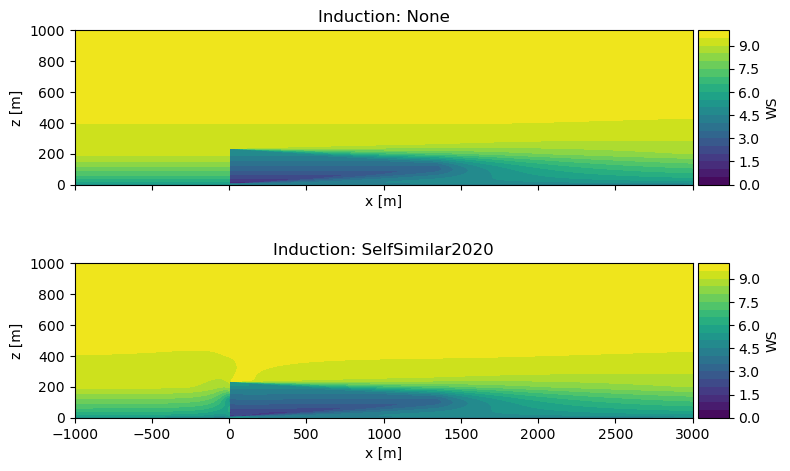

In [12]:
states = foxes.input.states.SingleStateStates(
    ws=8.0, wd=270.0, ti=0.04, rho=1.225, z0=1e-4, MOL=200, H=120,
    profiles={FV.WS: "ABLLogStableWsProfile"})

fig, axs = plt.subplots(2, 1, figsize=(8, 5), sharex=True, sharey=True)
ax = axs.ravel()

bmodels = {"None": [], "SelfSimilar2020": ["SelfSimilar2020"]}
with foxes.utils.runners.DaskRunner() as runner:
    for i, (bname, wakes0) in enumerate(bmodels.items()):

        algo = foxes.algorithms.Iterative(
            farm,
            states,
            rotor_model="grid36",
            wake_models=wakes0 + ["IECTI2019_quartic", "Bastankhah2016_linear_lim_k004"],
            wake_frame="rotor_wd",
            partial_wakes="rotor_points",
            ground_models={"SelfSimilar2020": "ground_mirror"},
            chunks={FC.STATE: None, FC.POINT: 4000},
            verbosity=0,
        )

        farm_results = runner.run(algo.calc_farm)

        o = foxes.output.FlowPlots2D(algo, farm_results, runner=runner)
        g = o.gen_states_fig_xz(
            var=FV.WS, resolution=2, 
            xmin=-1000, xmax=3000,
            zmin=0, zmax=1000,
            levels=20, 
            fig=fig,
            ax=ax[i],
            title=f"Induction: {bname}"
        )
        fig = next(g)

fig.tight_layout()
plt.show()